# Simulating Language 13, Iterated Bayesian Learning (lab) (some answers)

This simulation features a replication of the Reali & Griffiths iterated learning model of the evolution of frequency distributions, and is built around a Bayesian model of inference.  This simulation allows you to explore the effects of learning bias on learning and cultural evolution, and also gives you your first chance to see under the hood of a Bayesian model. But before we get onto the model itself, we need to talk about log probabilities.

In [1]:
from math import log, exp

## Introduction to log probabilities

In the lectures I introduced Bayes’ Rule as a relationship between probabilities: the posterior is proportional to the product of the likelihood and the prior, and all three of these quantities are probabilities. Doing Bayesian models of learning therefore involves manipulating probabilities, numbers between 0 and 1. And some of these probabilities can be very small indeed, because they involve multiplying small numbers lots of times (consider, for instance, how small the probability is of getting 100 heads if you flip a fair coin 100 times: it’s 0.5 x 0.5 x 0.5 ... 100 times, or $0.5^{100}$ if you prefer. That’s a very small number.)

Working with small numbers on a computer can be a problem, because the computer cannot exactly represent real numbers (i.e. numbers we would write in decimal notation, e.g. numbers like 0.1, 3.147). Your computer has a very large memory where it can store and manipulate numbers, but the problem is that this memory is necessarily finite (it has to fit in your computer) and there are infinitely many real numbers. Think of recurring decimal you get by dividing 1 by 3, 0.3333..., where the threes go on forever - it would take an infinite amount of space to exactly represent this number in your computer, and distinguish it from a very similar number, e.g. 0.33333... where the threes go on for a few thousand repetitions only. So there’s no way your computer can exactly represent every possible real number. What it does instead is store numbers as accurately as it can, which involves introducing small rounding errors. In fact your computer does its best to conceal these errors from you, and often displays numbers in a format that hides exactly what numbers it is actually working with. 

Why do you need to care about this? Well, if you are dealing with very very small numbers (as you might do if you were doing a Bayesian model which involves learning from lots of data) then the rounding errors become a real factor - for big numbers the rounding errors are so small we don’t really care, but for very small numbers, the rounding errors might be relatively big. Worse, sometimes the computer will round a very very small number to 0, which can generate unexpected and hard-to-predict errors in your code (e.g. if you try to divide something by a very very small number which gets rounded to 0).  

The solution to this is to have the computer work not with probabilities, but with log probabilities: we take our probabilities, take the log of those numbers, then carry on as before. 

In [2]:
print(log(1))
print(log(0.1))
print(log(0.000001))
print(exp(log(0.5)))
print(exp(log(0.1)))

0.0
-2.3025850929940455
-13.815510557964274
0.5
0.10000000000000002


As you can see from the code above, taking the log of a very small number turns it into a large negative number - these are still real numbers, so the computer still can’t represent them exactly, but in the log domain the rounding errors will be proportionately smaller for very small numbers and the rounding-to-0 problem won’t crop up. Then, if we want to see an actual probability, rather than a log probability, we can reverse this process, using the exp function, to get back raw probabilities. Jumping back and forth from logs can introduce rounding errors of its own, but it’s necessary to avoid the catastrophic rounding errors you can get if you just work with raw probabilities. 

Some basic arithmetic operations work a bit differently with logs. If you want to multiply two probabilities, you add their logarithms; if you want to divide one probability by another, you subtract the logarithm of one from another. And there is no direct equivalent of adding and subtracting in the log domain, which involves a little bit of fancy footwork in the code that you don’t have to worry about too much. The important thing is 1) to understand that the code is going to manipulate log probabilities and 2) this changes nothing conceptually, it’s just a matter of implementation.

In [3]:
print(0.5 * 0.5)
print(exp(log(0.5) + log(0.5)))
print(0.5 / 0.5)
print(exp(log(0.5) - log(0.5)))

0.25
0.25
1.0
1.0


## On to the code

First, loading in the usual extra functions, plus some more that are specifically for doing stuff with log probabilities and probability distributions.

In [4]:
import random
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

from scipy.stats import beta
from scipy.special import logsumexp
from math import log, log1p, exp

The code starts with various bits and pieces which we need for working with logs and probability distributions. In particular, it loads in a function called `logsumexp` which allows us to do addition in the log domain (remember, just using the normal addition operator + with logs is the equivalent of multiplying the non-logs). Then there is a function called `log_subtract` which allows us to do the equivalent of subtraction in the log domain (because if we just use normal subtraction, -, that’s equivalent to division). Then there are a couple of functions which we need for doing probabilistic sampling the log domain - `normalize_logprobs` will take a list of logs and normalise them for us (the equivalent of taking a list of pseudo-probabilities and rescaling them so they sum to 1, but in the log domain) and `log_roulette_wheel` takes a list of log probabilities and selects a random index from that list, with probability of any particular index being selected being given by its log probability. These functions are used elsewhere in the code, but it is not important that you understand exactly how they work. 

In [5]:
def log_subtract(x,y):
    return x + log1p(-exp(y - x))
 
def normalize_probs(probs):
    total = sum(probs) #calculates the summed log probabilities
    normedprobs = []
    for p in probs:
        normedprobs.append(p / total) #normalise - subtracting in the log domain
                                      #equivalent to dividing in the normal domain
    return normedprobs

def normalize_logprobs(logprobs):
    logtotal = logsumexp(logprobs) #calculates the summed log probabilities
    normedlogs = []
    for logp in logprobs:
        normedlogs.append(logp - logtotal) #normalise - subtracting in the log domain
                                           #equivalent to dividing in the normal domain
    return normedlogs
 
def log_roulette_wheel(normedlogs):
    r=log(random.random()) #generate a random number between 0 and 1, then convert to log
    accumulator = normedlogs[0]
    for i in range(len(normedlogs)):
        if r < accumulator:
            return i
        accumulator = logsumexp([accumulator, normedlogs[i + 1]])

The main part of the code starts by setting up the grid. As discussed in class, we are going to turn a problem of inferring a potentially continuous value (the probability with which your teacher uses word 1) into a problem of inferring one of a limited set of possible values (either your teacher is using the word with probability 0.005, or 0.015, or 0.025, etc). In the code we will refer to a certain probability of using word 1 as `pW1`.  We will call this set of possible values for `pW1` the grid - you can set the granularity of the grid as high as you like, but 100 works OK without being too slow. We are actually going to maintain two grids - one of probabilities, and one of log probabilities (since we are going to work with log probabilities when we do our calculations). 

In [6]:
grid_granularity = 100
grid_increment = 1 / grid_granularity
 
# sets up the grid of possible probabilities to consider
possible_pW1 = []
for i in range(grid_granularity):
    possible_pW1.append(grid_increment / 2 + (grid_increment * i))

# sets up the grid of log probabilities
possible_logpW1 = []
for pW1 in possible_pW1:
    possible_logpW1.append(log(pW1))

Have a look at the two grids (`possible_pW1` and `possible_logpW1`). Do they look like you expected?

Next up come the various functions we need for Bayesian inference. I will step through these gradually.

### The prior

In [7]:
def calculate_prior(alpha):
    logprior = []
    for pW1 in possible_pW1:
        logprior.append(beta.pdf(pW1, alpha, alpha)) 
    return normalize_probs(logprior)

def calculate_logprior(alpha):
    logprior = []
    for pW1 in possible_pW1:
        logprior.append(beta.logpdf(pW1, alpha, alpha)) 
    return normalize_logprobs(logprior) 

There are two functions for calculating the prior probability distribution, the prior probability of each of our possible values of `pW1`. One of these returns raw probabilities, so you can look at the prior easily without worrying about logs. The second, which is the one our code actually uses, calculates the log probability distribution - i.e. it deals with log probabilities, not logs. The beta distribution, which is what we are using for our prior, is a standard probability distribution, so we can just use a function from a library (`beta.pdf` for raw probabilities, `beta.logpdf` for log probabilities) to get the probability density for each value of `pW1`, then normalise those to convert them to probabilities.  

- Plot some different prior probability distributions - for example, try typing `plt.plot(possible_pW1, calculate_prior(0.1))` to see the prior probability distribution over various values of `pW1` for the `alpha=0.1` prior. 
- What values of alpha lead to a prior bias for regularity? 
- What values of alpha lead to a prior bias for variability? 
- What values of alpha lead to a completely unbiased learner?

Text(0,0.5,'Density')

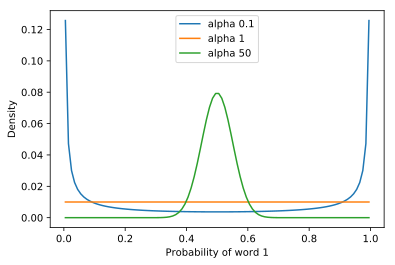

In [8]:
plt.plot(possible_pW1, calculate_prior(0.1), label="alpha 0.1")
plt.plot(possible_pW1, calculate_prior(1), label="alpha 1")
plt.plot(possible_pW1, calculate_prior(50), label="alpha 50")
plt.legend()
plt.xlabel("Probability of word 1")
plt.ylabel("Density")


### Likelihood and production

In order to do Bayesian inference, we need a likelihood function that tells us how probable a set of data is given a certain hypothesis (a value of `pW1`). And to do iterated learning we need a way of modelling production - taking an individual, with a value of `pW1` in their head, and having them produce data that someone else can learn from. The next two functions do that job.

In [9]:
def likelihood(data, logpW1):
    logpW0 = log_subtract(log(1), logpW1) #probability of w0 is 1-prob of w1
    logprobs = [logpW0, logpW1]
    loglikelihoods = []
    for d in data:
        loglikelihood_this_item = logprobs[d] #d will be either 0 or 1, 
                                              #so can use as index
        loglikelihoods.append(loglikelihood_this_item)
    return sum(loglikelihoods) #summing log probabilities = 
                               #multiply non-log probabilities
    
def produce(logpW1, n_productions):
    logpW0 = log_subtract(log(1), logpW1)
    logprobs = [logpW0, logpW1]
    data = []
    for p in range(n_productions):
        data.append(log_roulette_wheel(logprobs))
    return data

We are going to model data - sets of utterances - as a simple list of 0s and 1s: the 0s correspond to occurrences of word 0, the 1s correspond to occurrences of word 1. Both functions take a (log) probability of word 1 being produced, and use that to calculate the probability of word 0 (which is 1 minus the probability of word 1). 

- Test out the produce function - remember, you need to feed it a log probability, so decide on a probability for w1 and then convert it to log using the log function. What kind of data will be produced if the probability of w1 is low? Or if it is high? 
- Next, check out the likelihood function - how does the likelihood of a set of data depend on the data and the probability of word 1? Remember that the likelihood function returns a log probability, so you can convert this to a probability using the exp function. 

In [10]:
print(produce(log(0.1), 20))
print(produce(log(0.9), 20))
print(exp(likelihood([1,1,0], log(0.1))))
print(exp(likelihood([1,1,0], log(0.9))))

[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1]
0.009000000000000008
0.08099999999999997


### Learning

In [11]:
def posterior(data, prior):
    posterior_logprobs = []
    for i in range(len(possible_logpW1)):
        logpW1 = possible_logpW1[i] 
        logp_h = prior[i] #prior probability of this pW1
        logp_d = likelihood(data, logpW1) #likelihood of data given this pW1
        posterior_logprobs.append(logp_h + logp_d) #adding logs = 
                                                   #multiplying non-logs
    return normalize_logprobs(posterior_logprobs) 
     
def learn(data,prior):
    posterior_logprobs = posterior(data, prior)
    selected_index = log_roulette_wheel(posterior_logprobs)
    return possible_logpW1[selected_index]

Now we have all the bits we need to calculate the posterior probability distribution, and therefore to do learning (by picking a hypothesis, a value of pW1, based on its posterior probability). 

 - Test out the learn function. To do this you will need to build a prior, and some data. For example:
```python
my_prior = calculate_logprior(1)
my_data = [0] * 2 + [1] * 2
print(my_data)
print(exp(learn(my_data, my_prior)))
print(exp(learn(my_data, my_prior)))
print(exp(learn(my_data, my_prior)))
```
This example shows how to test a uniform prior (alpha = 1) and data consisting of two 1s and two 0s (note that there is a cute little trick there for creating lists of duplicates and sticking two lists together). Note that the result is probabilistic. A different hypothesis about the value of pW1 (the probability of word one) is picked each time. A better approach to understanding what's going on would be to use a for loop, build a list of running `learn` a bunch of times, and then using `plt.hist` to look at the output.

Start with a uniform prior and see how the data affects the learner’s hypothesis. 

- What does adding more data do? 
- What does making the data highly skewed in favour of one word do? 
- Try different priors - what does a strong prior in favour of regularity do? 
- What does a strong prior in favour of variability do? 

In [12]:
my_prior = calculate_logprior(1)
my_data = [0] * 2 + [1] * 2
print(my_data)
print(exp(learn(my_data, my_prior)))
print(exp(learn(my_data, my_prior)))
print(exp(learn(my_data, my_prior)))

[0, 0, 1, 1]
0.545
0.675
0.255


Text(0.5,0,'probability of word 1')

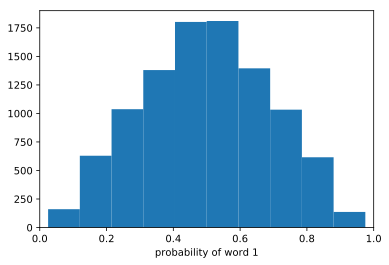

In [100]:
results = []
my_data = [0] * 2 + [1] * 2
for i in range(10000):
    results.append(exp(learn(my_data, my_prior)))
plt.hist(results, bins=10)
plt.xlim(0,1)
plt.xlabel("probability of word 1")

Text(0.5,0,'probability of word 1')

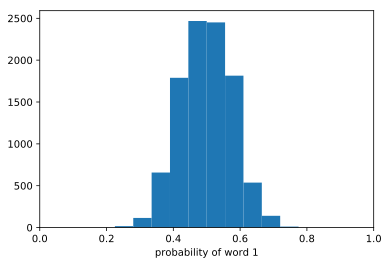

In [101]:
results = []
my_data = [0] * 20 + [1] * 20
for i in range(10000):
    results.append(exp(learn(my_data, my_prior)))
plt.hist(results, bins=10)
plt.xlim(0,1)
plt.xlabel("probability of word 1")

Text(0.5,0,'probability of word 1')

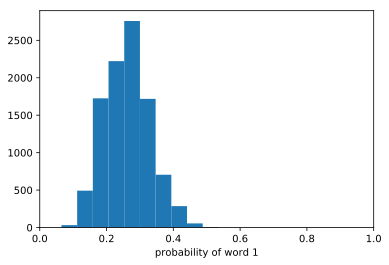

In [102]:
results = []
my_data = [0] * 30 + [1] * 10
for i in range(10000):
    results.append(exp(learn(my_data, my_prior)))
plt.hist(results, bins=10)
plt.xlim(0,1)
plt.xlabel("probability of word 1")

Text(0.5,0,'probability of word 1')

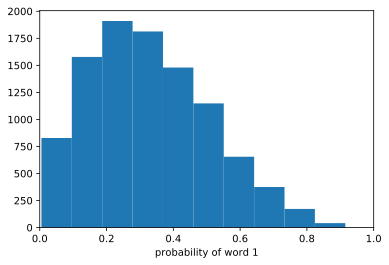

In [103]:
results = []
my_data = [0] * 3 + [1] * 1
for i in range(10000):
    results.append(exp(learn(my_data, my_prior)))
plt.hist(results, bins=10)
plt.xlim(0,1)
plt.xlabel("probability of word 1")

Text(0.5,0,'probability of word 1')

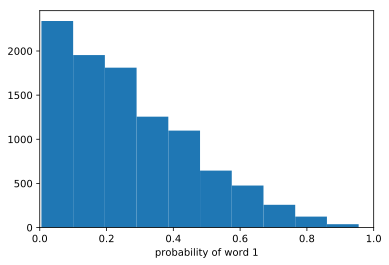

In [104]:
my_prior = calculate_logprior(0.1)
results = []
my_data = [0] * 3 + [1] * 1
for i in range(10000):
    results.append(exp(learn(my_data, my_prior)))
plt.hist(results, bins=10)
plt.xlim(0,1)
plt.xlabel("probability of word 1")

Text(0.5,0,'probability of word 1')

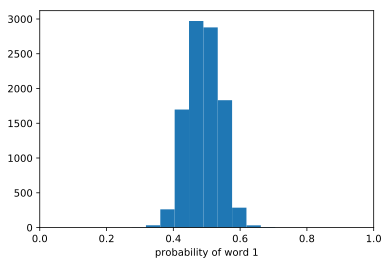

In [105]:
my_prior = calculate_logprior(50)
results = []
my_data = [0] * 3 + [1] * 1
for i in range(10000):
    results.append(exp(learn(my_data, my_prior)))
plt.hist(results, bins=10)
plt.xlim(0,1)
plt.xlabel("probability of word 1")

### Iteration

At last, we have all the bits we need to do iterated learning: we can have a learner infer a value of pW1 given some observed data, then we can have that individual produce data which another individual can learn from.

You can run a simulation using something like:

```python
pW1_by_generation, data_by_generation = iterate(0.1, 10, 5, 10)
``` 

This will run the simulation for 10 generations, using a prior defined by alpha=0.1, each learner observes 10 data points before inferring pW1, and the initial language consists of 5 examples of word 1 (and therefore 5 of word 0). It returns two  values: a generation-by-generation record of the inferred values of pW1, and the data produced at each generation (specified as a number of occurences of word 1). It's worth plotting these values as a graph over time, but also looking at the histogram of the values to get a sense of how they are distributed overall.

In [13]:
def iterate(alpha, n_productions, starting_count_w1, generations):
    prior = calculate_logprior(alpha)
    pW1_accumulator = []
    data_accumulator = []
    data = [1] * starting_count_w1 + [0] * (n_productions - starting_count_w1)
    for generation in range(generations):
        logpW1 = learn(data, prior)
        data = produce(logpW1, n_productions)
        pW1_accumulator.append(exp(logpW1))
        data_accumulator.append(sum(data))
    return pW1_accumulator, data_accumulator

Text(0.5,0,'probability of word 1')

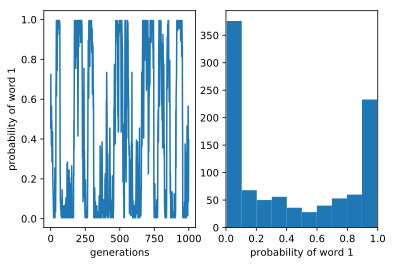

In [107]:
pW1_by_generation, data_by_generation = iterate(0.1, 10, 5, 1000)

fig, axs = plt.subplots(nrows=1, ncols=2)

axs[0].plot(pW1_by_generation)
axs[0].set_xlabel("generations")
axs[0].set_ylabel("probability of word 1")
axs[1].hist(pW1_by_generation)
axs[1].set_xlim(0, 1)
axs[1].set_xlabel("probability of word 1")


Text(0.5,0,'probability of word 1')

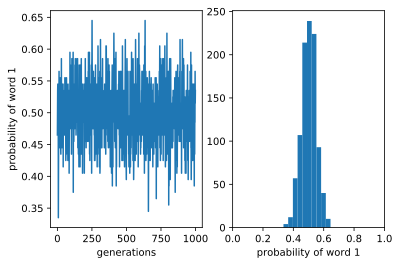

In [108]:
pW1_by_generation, data_by_generation = iterate(50, 10, 5, 1000)

fig, axs = plt.subplots(nrows=1, ncols=2)

axs[0].plot(pW1_by_generation)
axs[0].set_xlabel("generations")
axs[0].set_ylabel("probability of word 1")
axs[1].hist(pW1_by_generation)
axs[1].set_xlim(0, 1)
axs[1].set_xlabel("probability of word 1")


Text(0.5,0,'probability of word 1')

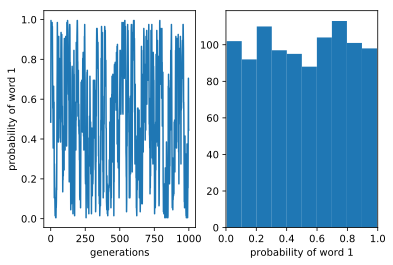

In [109]:
pW1_by_generation, data_by_generation = iterate(1, 10, 5, 1000)

fig, axs = plt.subplots(nrows=1, ncols=2)

axs[0].plot(pW1_by_generation)
axs[0].set_xlabel("generations")
axs[0].set_ylabel("probability of word 1")
axs[1].hist(pW1_by_generation)
axs[1].set_xlim(0, 1)
axs[1].set_xlabel("probability of word 1")


## Questions

The priority for this worksheet is to work through the in-text questions above: experimenting with the prior, checking that the likelihood and production makes sense, checking you understand how learning depends on the prior and the data. Once you are happy with that, try these questions:

1. One of Reali & Griffiths’s main points was that studying learning in a single individual can be a bad way to discover their prior bias, particularly if you give them lots of data which swamps this prior bias - given enough data, learners with quite different priors look the same. Can you reproduce this effect using this code?

Text(0.5,0,'Probability of word 1')

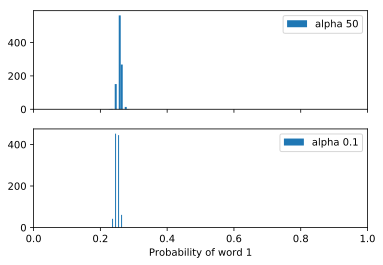

In [114]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)    

my_prior = calculate_logprior(50)
results = []
my_data = [0] * 3000 + [1] * 1000
for i in range(1000):
    results.append(exp(learn(my_data, my_prior)))

axs[0].hist(results, label="alpha 50")
axs[0].set_xlim(0,1)
axs[0].legend()

my_prior = calculate_logprior(0.1)
results = []
my_data = [0] * 3000 + [1] * 1000
for i in range(1000):
    results.append(exp(learn(my_data, my_prior)))

axs[1].hist(results, label="alpha 0.1")
axs[1].set_xlim(0,1)
axs[1].legend()

axs[1].set_xlabel("Probability of word 1")

2. Iterated learning can potentially give a clearer picture of prior bias. Try running some simulations for 10 generations, with 10 data points passed from generation to generation, starting each simulation with 5 instances of w1 and 5 of w0. How does changing the prior change the results?  Try alpha=0.1, alpha=1, and alpha=5. Are the differences between different priors obvious after generation 1, or do they become more apparent over generations?
3. Now try messing with the amount of data that is passed from generation to generation (remember to change the starting count of the w1 so you can compare between the different data set sizes fairly). What happens if you pass more data between generations? What happens if you pass less? What happens if you pass no data from generation to generation? What would this latter setting correspond to in the real world?

Text(0.5,0,'p(w1)')

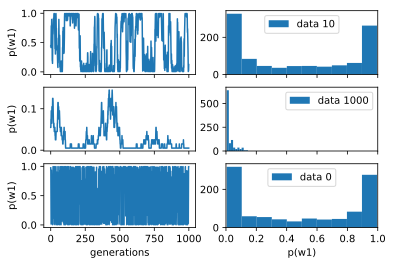

In [16]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex="col")    

pW1_by_generation, data_by_generation = iterate(0.1, 10, 5, 1000)
axs[0][0].plot(pW1_by_generation)
axs[0][0].set_ylabel("p(w1)")
axs[0][1].hist(pW1_by_generation, label="data 10")
axs[0][1].set_xlim(0,1)
axs[0][1].legend()

pW1_by_generation, data_by_generation = iterate(0.1, 1000, 50, 1000)
axs[1][0].plot(pW1_by_generation)
axs[1][0].set_ylabel("p(w1)")
axs[1][1].hist(pW1_by_generation, label="data 1000")
axs[0][1].set_xlim(0,1)
axs[1][1].legend()

pW1_by_generation, data_by_generation = iterate(0.1, 0, 0, 1000)
axs[2][0].plot(pW1_by_generation)
axs[2][0].set_ylabel("p(w1)")
axs[2][1].hist(pW1_by_generation, label="data 0")
axs[0][1].set_xlim(0,1)
axs[2][1].legend()

axs[2][0].set_xlabel("generations")
axs[2][1].set_xlabel("p(w1)")
